In [1]:
import re
import random
import numpy as np
from tqdm import trange
from newspaper import Article

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
 
from transformers.models import gpt2
from transformers import GPT2Config, GPT2LMHeadModel

import matplotlib.pyplot as plt
%matplotlib inline

In [319]:
# define the config to be used
vocab_size = 38
tinyconf = GPT2Config(
  vocab_size=vocab_size,
  n_positions=1024,
  n_ctx=1024,
  n_embd=128,
  n_layer=12,
  n_head=8
)

In [329]:
# from previous experiment
text_lengths = np.array([  50,   59,   69,   79,   89,   99,  109,  118,  128,  138,  148,
        158,  168,  177,  187,  197,  207,  217,  227,  236,  246,  256,
        266,  276,  286,  295,  305,  315,  325,  335,  345,  354,  364,
        374,  384,  394,  404,  414,  423,  433,  443,  453,  463,  473,
        482,  492,  502,  512,  522,  532,  541,  551,  561,  571,  581,
        591,  600,  610,  620,  630,  640,  650,  659,  669,  679,  689,
        699,  709,  719,  728,  738,  748,  758,  768,  778,  787,  797,
        807,  817,  827,  837,  846,  856,  866,  876,  886,  896,  905,
        915,  925,  935,  945,  955,  964,  974,  984,  994, 1004, 1014,
       1024])

from time import time

## Torch GPT

In [331]:
# startiGPT2LMHeadModelh GPT-2 from HF
model = GPT2LMHeadModel(tinyconf)
model.eval()
print("Num params:", model.num_parameters())

@torch.no_grad()
def generate(
  input_ids,
  max_length,
  num_return_sequences = 10
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.unsqueeze(0)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  input_ids = torch.tile(input_ids, [num_return_sequences, 1])
  
  for i in range(S+1, max_length+1, 1):
    logits = model(input_ids).logits[:, -1, :] # only the last token
    
    # sample next tokens randomly
    probs = F.softmax(logits, dim=-1)
    ix = torch.multinomial(probs, num_samples=1).view(-1, 1)
    input_ids = torch.cat([input_ids, ix], dim = -1)

Num params: 2515456


In [324]:
sample_inputs = torch.randint(low = 0, high = vocab_size, size = (1, 10))
time_per_seq_vanilla_gpt = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_inputs, max_length)
  time_per_seq_vanilla_gpt[max_length] = time() - st

 33%|███▎      | 33/100 [24:26<49:37, 44.45s/it]   


KeyboardInterrupt: 

In [325]:
time_per_seq_vanilla_gpt.values()

dict_values([1.6622998714447021, 2.1930811405181885, 2.992302894592285, 4.197546005249023, 5.14570689201355, 6.395497798919678, 8.011377096176147, 8.973557949066162, 10.591028928756714, 12.37233304977417, 14.557507038116455, 17.12027907371521, 19.828334093093872, 22.53909397125244, 25.5178701877594, 28.907083988189697, 32.55218505859375, 36.469399213790894, 40.74887204170227, 45.735422134399414, 49.355974197387695, 54.34034514427185, 59.26567196846008, 64.68545269966125, 71.53783798217773, 76.03711295127869, 82.26391291618347, 85.60085558891296, 89.99368333816528, 95.99286603927612, 104.54243302345276, 110.8418390750885, 117.99759483337402])

In [334]:
sample_inputs = torch.randint(low = 0, high = vocab_size, size = (1, 10))
hf_gpt = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  model.generate(sample_inputs, max_length, do_sample = True, num_return_sequences=10, pad_token_id = 50256)
  hf_gpt[max_length] = time() - st

100%|██████████| 100/100 [29:27<00:00, 17.67s/it]


In [337]:
np.array(list(hf_gpt.values()))

array([ 0.54495478,  0.73299313,  0.89063501,  0.8986249 ,  1.10433006,
        1.39928913,  1.48570991,  1.69396377,  1.79820895,  2.0881021 ,
        2.33569813,  2.51664615,  2.8236711 ,  2.74206328,  3.06350803,
        3.31710911,  3.92217016,  4.50567102,  4.63530302,  5.46945906,
        4.54229307,  4.94176412,  5.30708218,  5.53489304,  5.55287886,
        6.05769897,  6.55479288,  6.47484994,  6.66257071,  7.02209496,
        7.227005  ,  7.45897579,  8.24314904,  7.8537209 ,  7.87742209,
        8.58612514,  9.98917794,  9.76387882,  9.84815788, 10.37017703,
       10.74239707, 11.12377501, 11.58302498, 11.92812705, 12.48084402,
       12.77035689, 13.1333189 , 13.60988283, 14.03921103, 14.45418215,
       15.24299717, 15.81887794, 16.71262121, 16.34567904, 16.66935301,
       17.20844507, 17.86577606, 18.36354089, 18.84506202, 19.3054769 ,
       19.76750112, 20.32446575, 20.85218191, 21.45198107, 22.07024384,
       23.16882825, 23.12747598, 24.58696795, 23.89066076, 25.44

In [340]:
# testing full GPT2 Small
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
print(model.num_parameters())

sample_inputs = torch.randint(low = 0, high = vocab_size, size = (1, 10))
hf_gpt_small = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  model.generate(sample_inputs, max_length, do_sample = True, num_return_sequences=10, pad_token_id = 50256)
  hf_gpt_small[max_length] = time() - st

  0%|          | 0/100 [00:00<?, ?it/s]

124439808


 44%|████▍     | 44/100 [32:41<41:36, 44.59s/it]  


KeyboardInterrupt: 

In [343]:
np.array(list(hf_gpt_small.values()))

array([ 4.66104198,  6.01691318,  7.20656204,  8.429111  ,  9.83679509,
       11.12766981, 12.62173486, 13.91161394, 15.35557485, 16.85949302,
       18.38110971, 20.11641026, 21.83768201, 23.38225818, 25.06135178,
       26.83561707, 28.68084717, 30.51669407, 32.492589  , 34.13120389,
       35.95620108, 37.91341186, 44.04446197, 43.17010403, 44.75529599,
       47.77914095, 52.37193012, 55.93168211, 58.02335215, 56.84589434,
       62.29041219, 63.25715995, 63.70156193, 65.28368807, 68.72804832,
       70.68075681, 74.58965921, 79.20702791, 82.66970396, 82.34983492,
       82.3500061 , 83.35055184, 81.76600194, 84.06219292])

In [342]:
sample_inputs = torch.randint(low = 0, high = vocab_size, size = (1, 10))
time_per_seq_vanilla_gpt_124 = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_inputs, max_length)
  time_per_seq_vanilla_gpt_124[max_length] = time() - st

  9%|▉         | 9/100 [21:02<3:32:47, 140.30s/it]


KeyboardInterrupt: 

In [344]:
np.array(list(time_per_seq_vanilla_gpt_124.values()))

array([ 37.19195414,  52.34601283,  76.42361617, 101.24192476,
       125.88396978, 157.562819  , 195.53068709, 228.61091113,
       270.90618801])

## ONNX runtime Transformer

In [345]:
# starting with GPT-2 from HF
# model = GPT2LMHeadModel(tinyconf)
model.eval()
model.num_parameters()

124439808

In [346]:
# Export the model

# since this is a very large model we cannot export this as a single ONNX graph
# we pass argument use_external_data_format=True in torch.onnx.export(), last arg
# this creates a weight blob for different layers. we create a folder for this
# so everything is consolidated
import os
export_folder = "./data/gpt"
export_onnx = export_folder + "/model.onnx"
os.makedirs(export_folder, exist_ok=True)

# unlike our MNIST example where the dimensionality of input was fixed to 784
# BERT and transformer models can have 2D dynamic input/output
dynamic_axes_dict = {
  0:'batch_size',
  1:'sequence_length'
}

# eval mode and 
model.eval()

# since the input is fully dynamic, tiny sequence will work for trace
sample_input = torch.randint(low = 0, high = tinyconf.vocab_size, size = (1, 4))

# export model
torch.onnx.export(
  model = model,
  args = (
    sample_input,
  ),                         # model input (or a tuple for multiple inputs)
  f = export_onnx,           # where to save the model (can be a file or file-like object)
  export_params=True,        # store the trained parameter weights inside the model file
  opset_version=11,          # the ONNX version to export the model to
  do_constant_folding=True,  # whether to execute constant folding for optimization
  input_names = [
    'input_ids'
  ],                         # the model's input names
  output_names = ['logits'], # the model's output names
  dynamic_axes={
    'input_ids': dynamic_axes_dict,
    'logits': dynamic_axes_dict,
  },                         # variable length axes
)

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/transformers/models/gpt2/modeling_gpt2.py:170: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  w = w / (float(v.size(-1)) ** 0.5)


In [347]:
# check model: for models >2GB use onnx.checker
import onnx
onnx.checker.check_model(export_onnx)

# next run the model and see
import onnxruntime
ort_session = onnxruntime.InferenceSession(export_onnx)

In [348]:
# correct solution:
def softmax(x):
  """Compute softmax values for each sets of scores in x."""
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0) # only difference

In [349]:
def generate(
  input_ids,
  max_length,
  num_return_sequences = 10,
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.reshape(1, *input_ids.shape)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  input_ids = np.tile(input_ids, [num_return_sequences, 1])
  
  for i in range(S+1, max_length+1, 1):
    ort_inputs = {"input_ids": input_ids}
    logits = ort_session.run(None, ort_inputs)[0][:, -1, :] # only the last token
    
    # sample next tokens randomly
    new_tokens = np.asarray([np.random.multinomial(10, softmax(o)).argmax() for o in logits]).reshape(-1, 1)
    input_ids = np.hstack([input_ids, new_tokens])

In [350]:
sample_input = np.random.randint(low = 0, high = vocab_size, size = (10))
time_per_seq_onnx_gpt = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_input, max_length)
  time_per_seq_onnx_gpt[max_length] = time() - st

  0%|          | 0/100 [00:05<?, ?it/s]


ValueError: sum(pvals[:-1]) > 1.0

## TransRNN (Vanilla + ONNXRuntime)

In [4]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from t2rmodel import T2R

In [355]:
# model = T2R.from_pretrained("gpt2", feature_size = 32)
# model.num_params
tinyconf = GPT2Config(**tinyconf.__dict__, feature_size = 32)
model = T2R(tinyconf)
model.num_params

2916608

In [356]:
model.wpe.weight.shape

torch.Size([1024, 128])

In [357]:
model.infer_init()

Preparing Model for inference


In [358]:
def top_k_logits(logits, k):
  v, ix = torch.topk(logits, k)
  out = logits.clone()
  out[out < v[:, [-1]]] = -1e10
  return out

def get_next_tokens(logits, top_k, do_sample, num_return_sequences):
  # get probabilities
  if top_k is not None:
    logits = top_k_logits(logits, top_k)
  probs = F.softmax(logits, dim=-1)

  # get top_k tokens for each 
  if do_sample:
    ix = torch.multinomial(probs, num_samples=num_return_sequences)
  else:
    _, ix = torch.topk(probs, k=num_return_sequences, dim=-1)

  # get scores
  # each_probs = probs[:, ix].view(-1)
  # v, ix = torch.topk(each_probs, num_return_sequences )
  # print(ix)

  return ix

# test vanilla generation
@torch.no_grad()
def vanilla_generation(
  input_ids,
  max_length,
  num_return_sequences = 10,
  top_k = 10,
  do_sample = True
):
  assert model.infer_ready, "Not ready for inference. see `T2RInfer.infer_init()`"

  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.unsqueeze(0)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  # make the times list
  st = time()
  times = [st]
  
  s_rnn, z_rnn = model.init_hidden()
  B,S = input_ids.shape
  for i in range(S):
    logits, s_rnn, z_rnn = model(input_ids[:, i].unsqueeze(0), s_rnn = s_rnn, z_rnn = z_rnn, i = i)
    times.append(time())

  ix = get_next_tokens(logits[:, -1, :], top_k, do_sample, num_return_sequences)
  generated_tokens = [ix[0]]

  if num_return_sequences > 1:
    # tile rnn_states for multiple batch generation
    s_rnn = [torch.tile(s, [num_return_sequences, 1, 1]) for s in s_rnn]
    z_rnn = [torch.tile(z, [num_return_sequences, 1, 1]) for z in z_rnn]

  for i in range(S, max_length - 1, 1):
    logits, s_rnn, z_rnn = model(ix.view(num_return_sequences, 1), s_rnn = s_rnn, z_rnn = z_rnn, i = i)
    ix = get_next_tokens(logits[:, -1, :], top_k, do_sample, num_return_sequences)
    generated_tokens.append(ix[0])
    
    # add way to keep only the top scoring ones here
    ix = ix[0]
    
    times.append(time())
    
  generated_tokens = [x.unsqueeze(-1) for x in generated_tokens]
  generated_tokens = torch.cat(generated_tokens, dim = 1)
  input_ids = torch.tile(input_ids, [num_return_sequences, 1])
  full_seq = torch.cat([input_ids, generated_tokens], dim = 1)
  # return full_seq
  
  # we return times for this test
  return times

In [359]:
# changing the method a little bit from GPTs, we instead let it generate maximum
# number of tokens for `n` number of rounds and mean the values for each run
# making the testing process much faster.

sample_inputs = torch.randint(low = 0, high = vocab_size, size = (1, 10))
time_per_seq_vanilla_t2r = []
n_tests = 10
for _ in trange(n_tests):
  st = time()
  this_run_times = vanilla_generation(
    input_ids = sample_inputs,
    max_length = 1024,
  )
  time_per_seq_vanilla_t2r.append(this_run_times)

100%|██████████| 10/10 [02:01<00:00, 12.20s/it]


In [360]:
vanilla_t2r = np.array(time_per_seq_vanilla_t2r)
# for each case subtract the start time of that generation i.e. first token
vanilla_t2r = vanilla_t2r[:, 1:] - vanilla_t2r[:, :1]
vanilla_t2r = np.mean(vanilla_t2r, 0)

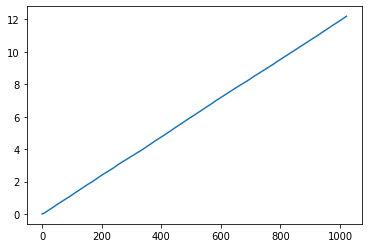

In [361]:
plt.plot(vanilla_t2r)

In [362]:
# Export the model

# since this is a very large model we cannot export this as a single ONNX graph
# we pass argument use_external_data_format=True in torch.onnx.export(), last arg
# this creates a weight blob for different layers. we create a folder for this
# so everything is consolidated
import os
export_folder = "./data/onnxrnn"
export_onnx = export_folder + "/model.onnx"
os.makedirs(export_folder, exist_ok=True)

# unlike our MNIST example where the dimensionality of input was fixed to 784
# BERT and transformer models can have 2D dynamic input/output
dynamic_axes_dict = {
  0:'batch_size',
}

# eval mode and 
model.eval()

# since the input is fully dynamic, tiny sequence will work for trace
sample_input = torch.randint(low = 0, high = tinyconf.vocab_size, size = (1, 1))
s, z = model.init_hidden()
i = torch.Tensor([0]).long()

# export model
torch.onnx.export(
  model = model,
  args = (
    sample_input, # input_ids
    None,
    None,
    s,            # s_rnn
    z,            # z_rnn
    i
  ),                         # model input (or a tuple for multiple inputs)
  f = export_onnx,           # where to save the model (can be a file or file-like object)
  export_params=True,        # store the trained parameter weights inside the model file
  opset_version=11,          # the ONNX version to export the model to
  do_constant_folding=True,  # whether to execute constant folding for optimization
  input_names = [
    'input_ids',
    *[f's.{i}' for i in range(len(s))],
    *[f'z.{i}' for i in range(len(z))],
    'i'
  ],                         # the model's input names
  output_names = [
    'logits',
    *[f'sout.{i}' for i in range(len(s))],
    *[f'zout.{i}' for i in range(len(s))],
  ], # the model's output names
  dynamic_axes={
    'input_ids': dynamic_axes_dict,
    **{f's.{i}':dynamic_axes_dict for i in range(len(s))},
    **{f'z.{i}':dynamic_axes_dict for i in range(len(z))},
    **{f'sout.{i}':dynamic_axes_dict for i in range(len(s))},
    **{f'zout.{i}':dynamic_axes_dict for i in range(len(z))},
  }, # variable length axes
  verbose = False
)

/Users/yashbonde/Desktop/AI/ks2labs/RNN-sim/t2rmodel.py:210: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[1] == 1, f"During inference only one token is allowed got: {x.shape}"


In [363]:
# check model: for models >2GB use onnx.checker
import onnx
onnx.checker.check_model(export_onnx)

# next run the model and see
import onnxruntime
ort_session = onnxruntime.InferenceSession(export_onnx)

In [364]:
[(x.name, x.shape, x.type) for x in ort_session.get_inputs()]

[('input_ids', ['batch_size', 1], 'tensor(int64)'),
 ('s.0', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.1', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.2', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.3', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.4', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.5', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.6', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.7', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.8', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.9', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.10', ['batch_size', 32, 128], 'tensor(float)'),
 ('s.11', ['batch_size', 32, 128], 'tensor(float)'),
 ('z.0', ['batch_size', 32, 8], 'tensor(float)'),
 ('z.1', ['batch_size', 32, 8], 'tensor(float)'),
 ('z.2', ['batch_size', 32, 8], 'tensor(float)'),
 ('z.3', ['batch_size', 32, 8], 'tensor(float)'),
 ('z.4', ['batch_size', 32, 8], 'tensor(float)'),
 ('z.5', ['batch_size', 32, 8], 'tensor(float)'),
 ('z.6', ['batch_size'

In [365]:
[(x.name, x.shape, x.type) for x in ort_session.get_outputs()]

[('logits', ['batch_size', 1, 38], 'tensor(float)'),
 ('sout.0', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.1', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.2', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.3', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.4', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.5', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.6', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.7', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.8', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.9', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.10', ['batch_size', 32, 128], 'tensor(float)'),
 ('sout.11', ['batch_size', 32, 128], 'tensor(float)'),
 ('zout.0', ['batch_size', 32, 8], 'tensor(float)'),
 ('zout.1', ['batch_size', 32, 8], 'tensor(float)'),
 ('zout.2', ['batch_size', 32, 8], 'tensor(float)'),
 ('zout.3', ['batch_size', 32, 8], 'tensor(float)'),
 ('zout.4', ['batch_size', 32, 8], 'tensor(float)'),
 ('zout.5', ['batch_

In [366]:
ort_inputs = {
  'input_ids': sample_input.numpy(),
  'i': np.ones([1,]).astype(int) * 12
}
s_rnn, z_rnn = model.init_hidden()
for i_, (s, z) in enumerate(zip(s_rnn, z_rnn)):
  ort_inputs.update({
    f"s.{i_}": s.numpy().astype(np.float32),
    f"z.{i_}": z.numpy().astype(np.float32),
  })

# pass through the model
ort_outs = ort_session.run(None, ort_inputs)

In [367]:
def onnx_generate(
  input_ids,
  max_length,
  num_return_sequences = 10,
  top_k = 10,
  do_sample = True
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.reshape(1, *input_ids.shape)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape
  assert B == 1, "Only 1 sequence at a time can be generated"
  
  times = [time()]

  # do the forward passes for input sequence
  for i in range(S):
    # create the dictionary for this input
    ort_inputs = {
      'input_ids': input_ids[:, i:i+1],
      'i': np.ones([1,]).astype(int) * i
    }
    if i == 0:
      s_rnn, z_rnn = model.init_hidden()
      for i_, (s, z) in enumerate(zip(s_rnn, z_rnn)):
        ort_inputs.update({
          f"s.{i_}": s.numpy().astype(np.float32),
          f"z.{i_}": z.numpy().astype(np.float32),
        })
    else:
      ort_inputs.update({f"s.{i_}":s for i_,s in enumerate(s_rnn)})
      ort_inputs.update({f"z.{i_}":z for i_,z in enumerate(z_rnn)})
    
    # pass through the model
    ort_outs = ort_session.run(None, ort_inputs)
    logits = ort_outs[0][0, 0]
    s_rnn = ort_outs[1:13]
    z_rnn = ort_outs[13:]
    
    times.append(time())

  # now we do tile for beam search
  new_tokens = logits.argsort()[::-1][:10][:num_return_sequences].reshape(-1, 1)
  s_rnn = np.tile(s_rnn, [num_return_sequences, 1, 1])
  z_rnn = np.tile(z_rnn, [num_return_sequences, 1, 1])
  generated_token = [new_tokens]
  
  # now we generate for other steps
  for i in range(S, max_length - 1, 1):
    ort_inputs = {
      'input_ids': new_tokens,
      'i': np.ones([1,]).astype(int) * i
    }
    ort_inputs.update({f"s.{i_}":s for i_,s in enumerate(s_rnn)})
    ort_inputs.update({f"z.{i_}":z for i_,z in enumerate(z_rnn)})
    
    # pass through the model
    ort_outs = ort_session.run(None, ort_inputs)
    logits = ort_outs[0][0, 0]
    s_rnn = ort_outs[1:13]
    z_rnn = ort_outs[13:]
    
    new_tokens = logits.argsort()[::-1][:10][:num_return_sequences].reshape(-1, 1)
    generated_token.append(new_tokens)
    
    times.append(time())
    
  # now finally tile input_ids and merge with generate tokens
  input_ids = np.tile(input_ids, [num_return_sequences, 1])
  generated_token = np.array(generated_token)[:, :, 0].T
  generated_token = np.hstack([input_ids, generated_token])
  # return generated_token
  
  return times

In [368]:
# test with ONNX runtime just like with Vanilla
sample_inputs = np.random.randint(low = 0, high = vocab_size, size = (10))
time_per_seq_onnx_t2r = []
n_tests = 10
for _ in trange(n_tests):
  this_run_times = onnx_generate(
    input_ids = sample_inputs,
    max_length = 1024,
    num_return_sequences = 10,
    top_k = 10,
    do_sample = True
  )
  time_per_seq_onnx_t2r.append(this_run_times)

100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


In [369]:
onnx_t2r = np.array(time_per_seq_onnx_t2r)
# for each case subtract the start time of that generation i.e. first token
onnx_t2r = onnx_t2r[:, 1:] - onnx_t2r[:, :1]
onnx_t2r = np.mean(onnx_t2r, 0)

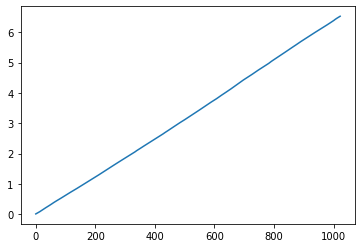

In [370]:
plt.plot(onnx_t2r)

In [371]:
times_onnx_t2r = onnx_t2r[text_lengths - 2] # -1 (for 0-shift), -1 (for bug in above code)
times_vanilla_t2r = vanilla_t2r[text_lengths - 2] # -1 (for 0-shift), -1 (for bug in above code)

times_onnx_t2r, times_vanilla_t2r

(array([0.30001078, 0.3603044 , 0.42240689, 0.48196082, 0.54125097,
        0.6023731 , 0.66296175, 0.71808777, 0.77635245, 0.83531108,
        0.89477158, 0.95519314, 1.01546245, 1.07159636, 1.13419592,
        1.19410977, 1.25383372, 1.31882656, 1.38073926, 1.43710034,
        1.50217981, 1.56583438, 1.62816389, 1.69034131, 1.7536243 ,
        1.80904608, 1.8686095 , 1.9296319 , 1.98867092, 2.05364389,
        2.12158947, 2.17747838, 2.2417171 , 2.30212214, 2.36518948,
        2.42551796, 2.48610356, 2.54596701, 2.60178342, 2.67385237,
        2.7381335 , 2.80237994, 2.86764221, 2.93438027, 2.99237921,
        3.05558076, 3.11647213, 3.17842669, 3.24511909, 3.31024184,
        3.3666657 , 3.43316984, 3.50073555, 3.56904719, 3.63326676,
        3.69783058, 3.75435944, 3.81718402, 3.88622403, 3.95263777,
        4.01813571, 4.08591025, 4.14504466, 4.21564918, 4.28588283,
        4.35968587, 4.42603579, 4.4884665 , 4.55309491, 4.61042697,
        4.68080883, 4.74614847, 4.80754242, 4.87

## Plot Results

In [15]:
import json
data = json.load(open("./times.json", "r"))

In [16]:

hftime = data["hftime"]
trtime = data["trtime"]
time_per_seq_vanilla_gpt = data["time_per_seq_vanilla_gpt"]
time_per_seq_onnx_gpt = data["time_per_seq_onnx_gpt"]
time_per_seq_onnx_rnn = data["time_per_seq_onnx_rnn"]
rnn_163Mn = data["rnn_163Mn"]
text_lengths = data["text_lengths"]

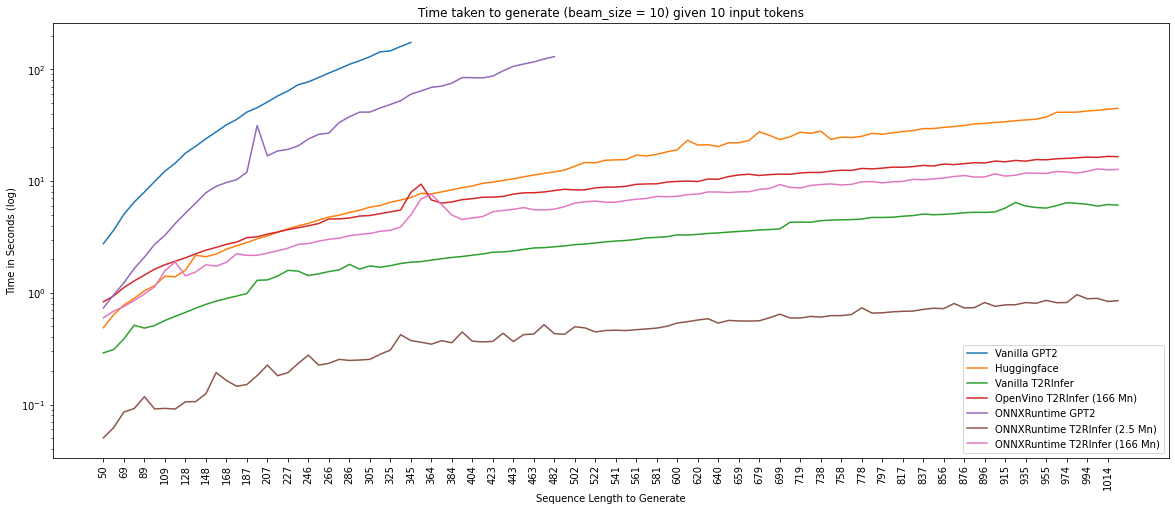

In [17]:
# create plots
plt.figure(figsize = (20, 8))
plt.plot(time_per_seq_vanilla_gpt)
plt.plot(hftime)
plt.plot(trtime)
plt.plot(openvino)
plt.plot(time_per_seq_onnx_gpt)
plt.plot(time_per_seq_onnx_rnn)
plt.plot(rnn_163Mn)
plt.ylabel("Time in Seconds (log)")
plt.xticks(
  ticks = np.arange(len(text_lengths) // 2) * 2,
  labels = np.array(text_lengths)[np.arange(0, len(text_lengths), 2)],
  rotation = 90
)
plt.xlabel("Sequence Length to Generate")
plt.legend([
  "Vanilla GPT2",
  "Huggingface",
  "Vanilla T2RInfer",
  "OpenVino T2RInfer (166 Mn)",
  "ONNXRuntime GPT2",
  "ONNXRuntime T2RInfer (2.5 Mn)",
  "ONNXRuntime T2RInfer (166 Mn)"
])
plt.title("Time taken to generate (beam_size = 10) given 10 input tokens")
plt.yscale("log")
plt.savefig("./raw_time_log.png")

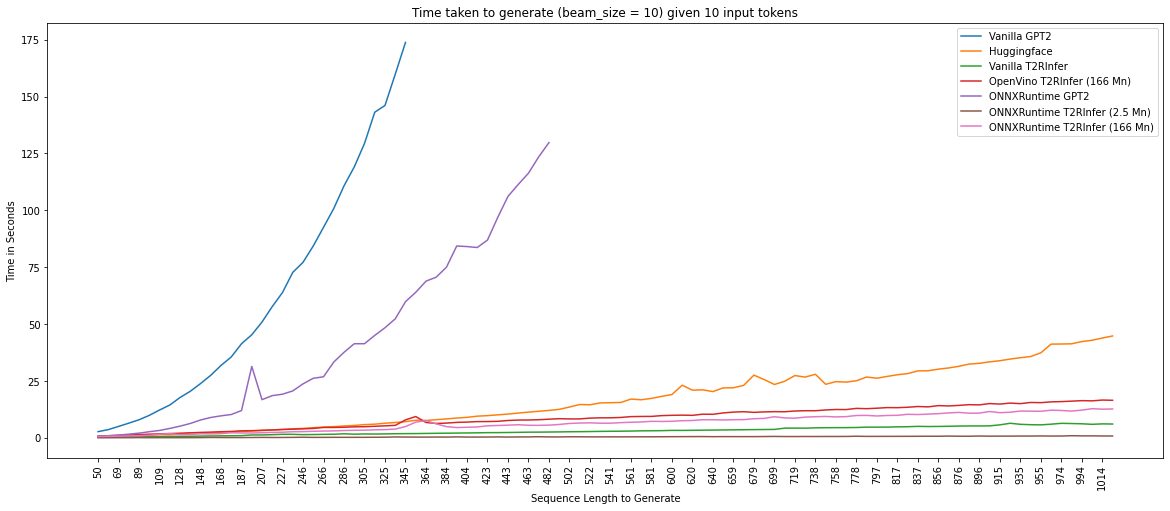

In [18]:
# create plots
plt.figure(figsize = (20, 8))
plt.plot(time_per_seq_vanilla_gpt)
plt.plot(hftime)
plt.plot(trtime)
plt.plot(openvino)
plt.plot(time_per_seq_onnx_gpt)
plt.plot(time_per_seq_onnx_rnn)
plt.plot(rnn_163Mn)
plt.ylabel("Time in Seconds")
plt.xticks(
  ticks = np.arange(len(text_lengths) // 2) * 2,
  labels = np.array(text_lengths)[np.arange(0, len(text_lengths), 2)],
  rotation = 90
)
plt.xlabel("Sequence Length to Generate")
plt.legend([
  "Vanilla GPT2",
  "Huggingface",
  "Vanilla T2RInfer",
  "OpenVino T2RInfer (166 Mn)",
  "ONNXRuntime GPT2",
  "ONNXRuntime T2RInfer (2.5 Mn)",
  "ONNXRuntime T2RInfer (166 Mn)"
])
plt.title("Time taken to generate (beam_size = 10) given 10 input tokens")
plt.savefig("./raw_time.png")

In [ ]:
np.argsort()

In [12]:
[x.shape for x in ort_outs]

[(1, 1, 50257), (1, 64, 768), (1, 1, 64)]

In [19]:
wpe = model.wpe.weight.data.numpy()
wte = model.wte.weight.data.numpy()
vocab_ = np.arange(tinyconf.vocab_size)

def generate(
  input_ids,
  max_length,
  num_return_sequences = 10
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.reshape(1, *input_ids.shape)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  # get the first set of embeddings and hidden states
  emb = wte[input_ids] + wte[:S]
  s = np.zeros((1, tinyconf.n_embd // tinyconf.n_head, tinyconf.n_embd)).astype(np.float32)
  z = np.zeros((1, 1, tinyconf.n_embd // tinyconf.n_head)).astype(np.float32)
  
  for i in range(emb.shape[1]):
    ort_inputs = {
      "input_ids": emb[:, i:i+1, :],
      "s": s,
      "z": z
    }
    logits, s, z = ort_session.run(None, ort_inputs)
    # s = s[0]; z = z[0]
  
  # randomly select tokens for next step
  new_tokens = np.random.choice(vocab_, size = (10,), p = softmax(logits[0][0])).reshape(-1, 1)
  s = np.tile(s, [num_return_sequences, 1, 1])
  z = np.tile(z, [num_return_sequences, 1, 1])
  
  for i in range(S+1, max_length, 1):
    emb = wte[new_tokens] + wpe[i:i+1]
    ort_inputs = {
      "input_ids": emb,
      "s": s,
      "z": z
    }
    logits, s, z = ort_session.run(None, ort_inputs)
    new_tokens = np.vstack([
      np.random.choice(vocab_, size = (1,), p = softmax(l)).reshape(-1, 1) for l in logits[:, -1, :]
    ])

In [20]:
sample_input = np.random.randint(low = 0, high = vocab_size, size = (10))
time_per_seq_onnx_rnn = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_input, max_length)
  time_per_seq_onnx_rnn[max_length] = time() - st

100%|██████████| 100/100 [14:42<00:00,  8.83s/it]


In [21]:
time_per_seq_onnx_rnn.values()

dict_values([0.8078258037567139, 0.9528629779815674, 1.023085117340088, 1.3267102241516113, 1.5955471992492676, 1.8665919303894043, 1.8290178775787354, 1.8734238147735596, 2.214817762374878, 2.4527370929718018, 2.6101157665252686, 2.7773261070251465, 2.825166940689087, 3.0728960037231445, 3.1171422004699707, 3.2865490913391113, 3.8310091495513916, 4.0839550495147705, 4.0467541217803955, 4.544752836227417, 4.173032999038696, 4.358557939529419, 4.804854154586792, 4.600397109985352, 5.0456459522247314, 5.197699069976807, 5.374312162399292, 5.388933181762695, 5.456713914871216, 5.8326921463012695, 5.692815065383911, 5.841047763824463, 6.03924822807312, 6.236928939819336, 6.3541340827941895, 6.537708044052124, 6.73204493522644, 7.014068841934204, 7.5250842571258545, 7.285407304763794, 7.551724672317505, 8.299933195114136, 8.144722938537598, 8.03302812576294, 8.304935932159424, 8.483222007751465, 8.32650113105774, 8.463954210281372, 8.645501852035522, 8.797425031661987, 9.641960144042969, 9.

In [268]:
time_per_seq_onnx_rnn.values()

dict_values([0.5959079265594482, 0.687363862991333, 0.75301194190979, 0.8533351421356201, 0.9747490882873535, 1.1346211433410645, 1.5717182159423828, 1.8908727169036865, 1.4194860458374023, 1.5369491577148438, 1.7827610969543457, 1.7322440147399902, 1.8739619255065918, 2.2371459007263184, 2.163003921508789, 2.167092800140381, 2.266625165939331, 2.3798720836639404, 2.505606174468994, 2.7107598781585693, 2.758840799331665, 2.9009530544281006, 3.0136170387268066, 3.0829598903656006, 3.2428767681121826, 3.333710193634033, 3.3943428993225098, 3.5502707958221436, 3.6275131702423096, 3.8873820304870605, 4.97966194152832, 6.926004886627197, 7.60387396812439, 6.169910192489624, 4.96052098274231, 4.541069984436035, 4.674930095672607, 4.807736158370972, 5.31633996963501, 5.458504915237427, 5.588108062744141, 5.786901950836182, 5.545657157897949, 5.516519069671631, 5.604123830795288, 5.9024059772491455, 6.349245309829712, 6.526838064193726, 6.617987155914307, 6.457239866256714, 6.4678730964660645,

In [14]:
openvino = list({50: 0.8308169841766357, 59: 0.9385421276092529, 69: 1.1165568828582764, 79: 1.2765130996704102, 89: 1.4416310787200928, 99: 1.6293408870697021, 109: 1.7819478511810303, 118: 1.9143421649932861, 128: 2.059094190597534, 138: 2.232140064239502, 148: 2.40683913230896, 158: 2.5497119426727295, 168: 2.717195987701416, 177: 2.8439559936523438, 187: 3.1171810626983643, 197: 3.1715948581695557, 207: 3.3493387699127197, 217: 3.4994089603424072, 227: 3.6750307083129883, 236: 3.8232548236846924, 246: 3.9808623790740967, 256: 4.163664817810059, 266: 4.583317995071411, 276: 4.583310127258301, 286: 4.672489166259766, 295: 4.858430862426758, 305: 4.918324947357178, 315: 5.102287292480469, 325: 5.300966024398804, 335: 5.502793073654175, 345: 7.916024208068848, 354: 9.381884813308716, 364: 6.780932188034058, 374: 6.352913856506348, 384: 6.500420808792114, 394: 6.815152883529663, 404: 6.956315040588379, 414: 7.163733005523682, 423: 7.183579206466675, 433: 7.287609815597534, 443: 7.648420095443726, 453: 7.841577053070068, 463: 7.861024856567383, 473: 7.98726487159729, 482: 8.216248035430908, 492: 8.442819118499756, 502: 8.333581686019897, 512: 8.349575996398926, 522: 8.693190813064575, 532: 8.815429210662842, 541: 8.82877516746521, 551: 8.983691930770874, 561: 9.351985931396484, 571: 9.420326948165894, 581: 9.446531057357788, 591: 9.79126787185669, 600: 9.925878763198853, 610: 10.005067110061646, 620: 9.90594220161438, 630: 10.42673373222351, 640: 10.369528770446777, 650: 10.969038963317871, 659: 11.338748216629028, 669: 11.508569717407227, 679: 11.2188138961792, 689: 11.422258853912354, 699: 11.534149169921875, 709: 11.492116928100586, 719: 11.815311670303345, 728: 11.94534707069397, 738: 11.941256999969482, 748: 12.272209167480469, 758: 12.487500190734863, 768: 12.45061707496643, 778: 12.9688401222229, 787: 12.84001898765564, 797: 13.045544147491455, 807: 13.321141958236694, 817: 13.282780170440674, 827: 13.46946907043457, 837: 13.7919921875, 846: 13.634413242340088, 856: 14.190178155899048, 866: 14.040977239608765, 876: 14.291153907775879, 886: 14.599408864974976, 896: 14.505081176757812, 905: 15.083547830581665, 915: 14.86729907989502, 925: 15.294875144958496, 935: 15.059892892837524, 945: 15.566175937652588, 955: 15.485416173934937, 964: 15.829054355621338, 974: 15.951651096343994, 984: 16.14839506149292, 994: 16.3699369430542, 1004: 16.278465032577515, 1014: 16.632145166397095, 1024: 16.529223203659058}.values())
openvino[-4:]

[16.3699369430542, 16.278465032577515, 16.632145166397095, 16.529223203659058]